In [1]:
'''
This script extracts the 2-m temperature and downward shortwave radiation flux from the HRRR grib2 data
071: 2m temperature
123: downward shortwave radiation flux

1 shortwave = 0.505 Photosynthetically Active Radiation [W.m-2]
1 W/m2 ≈ 4.6 μmole.m-2.s-1
'''

import gdal,ogr,osr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import datetime
import time
import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import math
import pytz
import os

DataDir   = "/data0/dwei/HRRR/2021/"

def utc_to_et(dt_utc):
    '''Input  is a Datetime type
       Output is a string, in the format of outputfmt
    '''
    utc = pytz.timezone('UTC')
    est = pytz.timezone('US/Eastern')   
    outputfmt  = '%Y-%m-%d %H:%M:%S'
    dt_est = utc.localize(dt_utc).astimezone(est).strftime(outputfmt)
    return dt_est

def get_NYC_bbox(target_EPSG):
    ''' 
    To get the bounding box of NYC
    '''   
    shapefile = "/data0/dwei/NYCshapefiles/geo_export_a8b5d138-820a-4931-8d11-fe8604ea5bd1.shp"
    
    # define shapefile driver
    drv         = ogr.GetDriverByName('ESRI Shapefile') 
    ds_in       = drv.Open(shapefile,0) 
    lyr_in      = ds_in.GetLayer()            # grab layer
    sourceprj   = lyr_in.GetSpatialRef()      # source projection
    targetprj   = osr.SpatialReference()
    targetprj.ImportFromEPSG(target_EPSG)     # target projection
    transform   = osr.CoordinateTransformation(sourceprj, targetprj)

    shp         = lyr_in.GetExtent()
    ll_x,ll_y,_ = transform.TransformPoint(shp[0],shp[2]) # reprojected bounds for city
    ur_x,ur_y,_ = transform.TransformPoint(shp[1],shp[3]) # reprojected bounds for city
    bbox        = [ll_x, ll_y, ur_x, ur_y]    # bounding box
    # print("The original prj is :\n", sourceprj)
    # print("The target   prj is :\n", targetprj)
    # print('NYC bbox :', bbox)
    return bbox  

def get_bbox_from_GeoTransform(ds):
    
    ysize=ds.RasterYSize
    xsize=ds.RasterXSize
    gt_hrrr=ds.GetGeoTransform()
    
    res_hrrr=gt_hrrr[1]
    ymax_hrrr=gt_hrrr[3]
    xmin_hrrr=gt_hrrr[0]
    
    ymin_hrrr=ymax_hrrr-res_hrrr*ysize
    xmax_hrrr=xmin_hrrr+xsize*res_hrrr
    bbox=[xmin_hrrr, ymin_hrrr, xmax_hrrr, ymax_hrrr]
    return bbox

def get_mesh_XY_from_DS(ds):
    
    gt=ds.GetGeoTransform()
    x_ul  = gt[0]
    y_ul  = gt[3]
    x_res = gt[1] # W-E resolution
    y_res = gt[5] # N-S resolution
    n_row = np.shape(ds.GetRasterBand(1).ReadAsArray())[0]
    n_col = np.shape(ds.GetRasterBand(1).ReadAsArray())[1]
    # print(x_ul, y_ul, x_res, y_res, n_row, n_col)
    xtst  = np.arange(x_ul, x_ul+x_res*n_col, x_res)
    ytst  = np.arange(y_ul, y_ul+y_res*n_row, y_res)
    X, Y  = np.meshgrid(xtst, ytst)
    return X, Y

def crop_grib2(grib2file, band, bbox):
    OutDir = '/data0/dwei/VPRMdata/HRRR/'
    
    # parameters
    target_EPSG=32618  # Landsat projection
    target_xRes=3000
    target_yRes=3000
    
    # Translate the grib2 format to tiff format
    ds   = gdal.Open(grib2file)
    out_orig = grib2file.replace('grib2', 'tif') 
    bandx = gdal.Translate(out_orig, ds, bandList=[band])

    # Reproject the raster file to the Landsat projection (32618)
    warp_srs = osr.SpatialReference()
    warp_srs.ImportFromEPSG(target_EPSG)   
    out_warped =grib2file.replace('grib2', 'warped.tif')
    warped_band =gdal.Warp(out_warped, bandx, dstSRS=warp_srs,\
                   xRes = target_xRes, yRes = target_yRes,\
                   dstNodata=None)

    # Crop the reprojected Gtiff to the region of interest
    out_NYC=grib2file.replace('grib2', 'cropped_B'+str(band)+'.tif')
    cropped_band=gdal.Warp(out_NYC, warped_band, \
                           dstSRS = warp_srs, outputBoundsSRS=warp_srs,\
                           xRes = target_xRes, yRes = target_yRes, \
                           outputBounds=bbox)  # outputBounds (minX, minY, maxX, maxY)
    os.remove(out_orig)
    os.remove(out_warped)
    return cropped_band

# Crop the HRRR a bit larger than NYC bbox
def bbox_new_HRRR(bbox_old):
    '''This function gives the smallest new bbox out of the conUS HRRR data that contains the old bbox
       bbox_old is the old bbox
    '''
    warped_hrrr=gdal.Open('/data0/dwei/sampledata/hrrr.t17z.wrfsfcf00.warped.tif')
    gt_hrrr=warped_hrrr.GetGeoTransform() # to rest if the HRRR files have the same GeoTransform
    res_hrrr=gt_hrrr[1]
    bbox_hrrr= get_bbox_from_GeoTransform(warped_hrrr)
    xmin_hrrr=bbox_hrrr[0]
    ymax_hrrr=bbox_hrrr[3]
    xmax_hrrr=bbox_hrrr[2]
    ymin_hrrr=bbox_hrrr[1]
    xmin_est=xmin_hrrr+math.floor(abs(xmin_hrrr-bbox_old[0])/res_hrrr)*res_hrrr
    ymax_est=ymax_hrrr-math.floor(abs(ymax_hrrr-bbox_old[3])/res_hrrr)*res_hrrr
    xmax_est=xmax_hrrr-math.floor((xmax_hrrr-bbox_old[2])/res_hrrr)*res_hrrr
    ymin_est=ymin_hrrr+math.floor(abs(ymin_hrrr-bbox_old[1])/res_hrrr)*res_hrrr
    bbox_new=[xmin_est, ymin_est, xmax_est, ymax_est]
    return bbox_new

# NYC bbox
target_EPSG = 32618              # Landsat projection
bbox = get_NYC_bbox(target_EPSG) # NYC minx miny maxx maxy
bbox_new=bbox_new_HRRR(bbox)
print("NYC bbox  ", bbox)
print("HRRR bbox ", bbox_new)



NYC bbox   [563086.4981809029, 4483346.578300821, 609468.3374729961, 4530140.279354534]
HRRR bbox  [560297.2385239592, 4482420.089913696, 611297.2385239592, 4530420.089913696]


In [2]:
start_time = time.time()

# Read the temperature and solar radiation data on a daily basis
start_date= datetime.date(2021, 10, 23)
end_date  = datetime.date(2022, 1, 1)
delta     = datetime.timedelta(days=1)
utz       = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09",\
             "10", "11", "12", "13", "14", "15", "16", "17", "18", "19",\
             "20", "21", "22", "23"]

TMP_ind = 71
DSW_ind = 123
target_xRes=3000
target_yRes=3000
NaN_272 = np.empty(16*17) # for missing hour; size: 16*17
NaN_272[:]= np.NaN

# loop through daily folder
time_ls=[]
X_1D=[]
Y_1D=[]
nump_tmp=[]
nump_dsw=[]
while start_date <= end_date: 
    date_str = datetime.datetime.strftime(start_date, "%Y%m%d") # string type
    folder = DataDir+"hrrr"+date_str+"/"
    
    # remove existing tif files
    tif_lst=glob.glob(folder+"*.tif")
    if tif_lst: # list is not empty
        for tif in tif_lst:
            os.remove(tif)
            
    print("---------------- Date: %s ----------------" %date_str)
    
    # loop through hourly files
    i = 0
    for z in utz:             
        filename = glob.glob(folder+"*t"+z+"z*") # a list
        
        if filename:  # file exists
            filestr  = str(filename[0]) # convert list to string
            # print(filestr)
            
            # Raster dataset
            ds_tmp = crop_grib2(filestr, 71, bbox_new)
#             tmp_2D=ds_tmp.GetRasterBand(1).ReadAsArray()
#             for x in tmp_2D.reshape(np.size(tmp_2D)):   
#                 nump_tmp.append(x)

            ds_dsw = crop_grib2(filestr, 123, bbox_new)
#             dsw_2D=ds_dsw.GetRasterBand(1).ReadAsArray()
#             for x in dsw_2D.reshape(np.size(dsw_2D)):
#                 nump_dsw.append(x)
                
#             # Get the coordinates 
#             X, Y = get_mesh_XY_from_DS(ds_tmp)
#             for x in X.reshape([np.size(X)]):
#                 X_1D.append(x)
#             for y in Y.reshape([np.size(Y)]):
#                 Y_1D.append(y)
                
        else:      # file does not exist
            filestr=None
            print("No such file on %s %s UTC" %(date_str, z))
            continue
#             for x in NaN_272:   
#                 nump_tmp.append(x)
#                 nump_dsw.append(x)
#                 X_1D.append(x)
#                 Y_1D.append(y)
                   
#         # Datetime
#         time_str=date_str+z # string type
#         time_dt=datetime.datetime.strptime(time_str, "%Y%m%d%H")
#         time_et=utc_to_et(time_dt)
#         # print("Eastern time : %s" %time_et)
#         for t in [time_et]*np.size(X):
#             time_ls.append(t)
        
        i+=1
    
    start_date += delta
    
# # To create a dataframe with time, coordinates (X, Y), and EVI   
# Data = pd.DataFrame({"Time":time_ls, "X":X_1D, 'Y':Y_1D, "TMP":nump_tmp, "DSW":nump_dsw})
# Data.to_csv(DataDir+'HRRR_TMP_DSW_NYC_20210416')
# print(Data.head())

print("================ Finished in %s minutes ============" \
      %(time.time()/60-start_time/60.))


# # Clear the output screen
# from IPython.display import clear_output
# clear_output



---------------- Date: 20211023 ----------------
---------------- Date: 20211024 ----------------
---------------- Date: 20211025 ----------------
---------------- Date: 20211026 ----------------
---------------- Date: 20211027 ----------------
---------------- Date: 20211028 ----------------
---------------- Date: 20211029 ----------------
---------------- Date: 20211030 ----------------
---------------- Date: 20211031 ----------------
---------------- Date: 20211101 ----------------
---------------- Date: 20211102 ----------------
---------------- Date: 20211103 ----------------
---------------- Date: 20211104 ----------------
---------------- Date: 20211105 ----------------
---------------- Date: 20211106 ----------------
---------------- Date: 20211107 ----------------
---------------- Date: 20211108 ----------------
---------------- Date: 20211109 ----------------
---------------- Date: 20211110 ----------------
---------------- Date: 20211111 ----------------
---------------- Dat

1799 1059
(-2699020.1425219304, 3000.0, 0.0, 1588193.8474433364, 0.0, -3000.0)


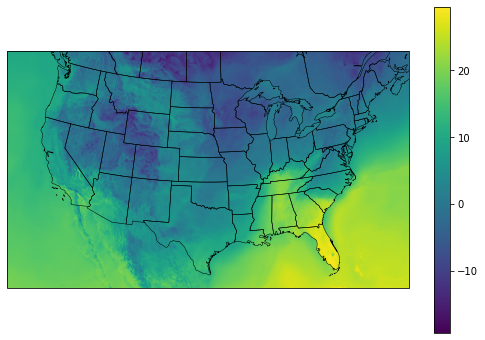

In [6]:
# Plot the HRRR grib2 data
Samplefile='/data0/dwei/sampledata/hrrr.t18z.wrfsfcf00.grib2'
ds=gdal.Open(Samplefile)
TMP=ds.GetRasterBand(71).ReadAsArray()

print(n_col, n_row)
print(ds.GetGeoTransform())
n_col=ds.RasterXSize
n_row=ds.RasterYSize
res = ds.GetGeoTransform()[1]
xmin=ds.GetGeoTransform()[0]
ymax=ds.GetGeoTransform()[3]
xmax=xmin+res*n_col
ymin=ymax-res*n_row

img_extent=(xmin, xmax, ymin, ymax)
prj_orig = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=prj_orig, )
# ax.coastlines()
ax.add_feature(cfeature.STATES, zorder=1, linewidth=0.5, edgecolor='k')
im = ax.imshow(TMP, origin='upper', extent=img_extent)
plt.colorbar(im)
